In [20]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [21]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [22]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [23]:
%matplotlib inline

In [24]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(3579, 35)
(3579, 4)


# Multivariate Linear Regression (Foot prediction)

In [25]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [26]:
# Entries where RL swings
idxs = np.where(X_motion[:, -1] == 1)[0]
X_motion_RL_swinging = X_motion[idxs]
Y_motion_RL_swinging = Y_motion[idxs]

## Predict RL foot -> x

In [27]:
X_motion_RL_swinging[0, :]

array([ 1.00000000e-01,  0.00000000e+00,  0.00000000e+00,  2.64709865e-01,
        1.29830395e-01, -3.38858272e-01,  2.41059778e-01, -1.22873789e-01,
       -3.55994009e-01, -2.74628820e-01,  1.29782037e-01, -3.56233204e-01,
       -2.54233944e-01, -1.33633125e-01, -3.41321720e-01,  2.92673776e+01,
        2.23080942e-01,  3.83204199e-01, -1.10287466e-03,  1.40351884e-03,
        2.32242352e-03,  9.99995710e-01,  7.73709330e-02,  1.98805996e-03,
       -3.05314867e-02,  3.67494038e-02, -7.95687880e-02,  1.68014647e-03,
                   nan,             nan,  2.00000000e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.00000000e+00])

In [28]:
X_motion_RL_swinging[0, :]

array([ 1.00000000e-01,  0.00000000e+00,  0.00000000e+00,  2.64709865e-01,
        1.29830395e-01, -3.38858272e-01,  2.41059778e-01, -1.22873789e-01,
       -3.55994009e-01, -2.74628820e-01,  1.29782037e-01, -3.56233204e-01,
       -2.54233944e-01, -1.33633125e-01, -3.41321720e-01,  2.92673776e+01,
        2.23080942e-01,  3.83204199e-01, -1.10287466e-03,  1.40351884e-03,
        2.32242352e-03,  9.99995710e-01,  7.73709330e-02,  1.98805996e-03,
       -3.05314867e-02,  3.67494038e-02, -7.95687880e-02,  1.68014647e-03,
                   nan,             nan,  2.00000000e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.00000000e+00])

### Linear Regression

In [29]:
# Input
X = np.hstack((X_motion_RL_swinging[:, :3], # Previous motion command
               X_motion_RL_swinging[:, -5:-2], # Current motion command
               X_motion_RL_swinging[:, 3:5], # FL (x,y) position
               X_motion_RL_swinging[:, 6:8], # FR (x,y) position
               X_motion_RL_swinging[:, 9:11], # RL (x,y) position
               X_motion_RL_swinging[:, 12:14])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RL_swinging[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rl_relative_swinging_x = LinearRegression()

# Fit the model
model_rl_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rl_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9632717805930858
RMSE:  0.02082952478897318
The lowest error is:  8.848213349677003e-06
The highest error is:  0.13223207999199882
The avg. error is:  0.014384182606786762


In [30]:
model_rl_relative_swinging_x.coef_

array([[ 2.85334868e-01, -1.25349088e+09,  2.02323379e+12,
         2.01140404e-01, -1.78823073e+09, -2.02323379e+12,
         1.50726801e+00,  1.50604673e+00,  3.19673717e-02,
        -9.80773211e-01, -7.45203100e-01,  9.07179311e-01,
        -2.57644302e+00, -1.78252668e+00]])

In [31]:
model_rl_relative_swinging_x.intercept_

array([-1.9632776])

Text(0, 0.5, 'Predictions')

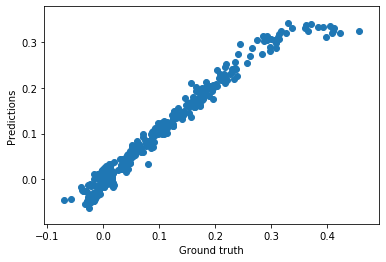

In [32]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [33]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict RL foot -> y

In [34]:
# Input
X = np.hstack((X_motion_RL_swinging[:, :3], # Previous motion command
               X_motion_RL_swinging[:, -5:-2], # Current motion command
               X_motion_RL_swinging[:, 3:5], # FL (x,y) position
               X_motion_RL_swinging[:, 6:8], # FR (x,y) position
               X_motion_RL_swinging[:, 9:11], # RL (x,y) position
               X_motion_RL_swinging[:, 12:14])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RL_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rl_relative_swinging_y = LinearRegression()

# Fit the model
model_rl_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rl_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9227699040210156
RMSE:  0.007171081186118588
The lowest error is:  6.2488820520845145e-06
The highest error is:  0.04301047768948968
The avg. error is:  0.0053207809012621055


In [35]:
model_rl_relative_swinging_y.coef_

array([[-1.04362134e-02, -3.29590006e+08,  5.31984436e+11,
         1.62805915e-02, -4.70193272e+08, -5.31984436e+11,
         5.82553089e-01,  2.46194430e-01, -7.35857189e-02,
         3.66420709e-02,  4.50676829e-02, -7.99261633e-01,
        -5.19630194e-01,  1.62783118e-01]])

In [36]:
model_rl_relative_swinging_y.intercept_

array([-0.15751274])

Text(0, 0.5, 'Predictions')

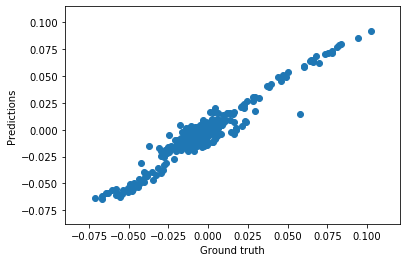

In [37]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [19]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')